In [52]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.stats.proportion as st
from sklearn.model_selection import train_test_split, KFold
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, mean_squared_error

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import time
import copy
import os

from ipynbHelper import *

pd.options.display.max_columns = None
%matplotlib inline

params = {'axes.titlesize':'32',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14'}
matplotlib.rcParams.update(params)


### Some hepler functions

In [14]:
def plot_fe(series, xlabel='', ylabel='', title='', figsize=(13, 10), font_size=14, sort=True):
    if sort:
        series = series.sort_values(ascending=False)
        
    plt.figure(figsize=figsize);
    sns.set(font_scale=font_size/10.0)
    ax = sns.barplot(x=series.values.reshape(1, -1)[0], y=series.index);
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=font_size)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=font_size)
    if title:
        ax.set_title(title, fontsize=font_size)
    plt.show()
    
def preproc_data(ldf, pred_clmns, y_col, test_size=0.2, random_state=523, cond=None):
    if cond is None:
        x_train, x_test, y_train, y_test = train_test_split(ldf[pred_clmns], ldf[y_col], test_size=test_size, random_state=random_state)
    else:
        
#     if 'alf' in y_col and 'istol' in y_col:
#         cond = ldf[y_col]!=0
        x_train, x_test, y_train, y_test = train_test_split(ldf[cond][pred_clmns], ldf[cond][y_col], test_size=test_size, random_state=random_state)
        
        
    print 'TRAIN SHAPE:', x_train.shape, 'TEST SHAPE:', x_test.shape
    if 'alf' in y_col and 'istol' in y_col:
        y_train.replace({-1: 0}, inplace=True)
        y_test.replace({-1: 0}, inplace=True)

    return x_train, x_test, y_train, y_test

def fit_model(params, x_train, x_test, y_train, y_test, weight_train=None, weight_test=None, modelname='lgb'):
    if modelname=='lgb':
        # define lgb train and validation Datasets
        d_train = lgb.Dataset(x_train, y_train, weight=weight_train)
        d_valid = lgb.Dataset(x_test, y_test, weight=weight_test)

        # train model
        print '\nSTART FITTING:'
        model = lgb.train(params=params, 
                        train_set=d_train, 
                        num_boost_round=5000, 
                        valid_sets=[d_valid],
                        verbose_eval=100, 
                        early_stopping_rounds=25)
        print 'FITTING HAS BEEN ENDED\n'
        
        print 'VALIDATION:'
        if params['objective']=='binary':
            train_pred = model.predict(x_train)
            test_pred = model.predict(x_test)

            print 'TRAIN ROC_AUC:', round(roc_auc_score(y_train, train_pred), 6), 'ACCURACY:', round(accuracy_score(y_train, np.round(train_pred)), 6)
            print 'TEST ROC_AUC:', round(roc_auc_score(y_test, test_pred), 6), 'ACCURACY:', round(accuracy_score(y_test, np.round(test_pred)), 6)
            
        else:#params['objective']=='regression'
            train_pred = model.predict(x_train)
            test_pred = model.predict(x_test)

            print 'TRAIN MAE:', round(mean_absolute_error(y_train, train_pred), 6), 'MSE:', round(mean_squared_error(y_train, train_pred), 6)
            print 'TEST MAE:', round(mean_absolute_error(y_test, test_pred), 6), 'MSE:', round(mean_squared_error(y_test, test_pred), 6)
            
        return model
    
    elif modelname=='rf':
        model = RandomForestRegressor(**params)
        
        print '\nSTART FITTING:'
        model.fit(x_train, y_train)
        print 'FITTING HAS BEEN ENDED\n'
        
        print 'VALIDATION:'
        train_pred = model.predict(x_train)
        test_pred = model.predict(x_test)

        print 'TRAIN MAE:', round(mean_absolute_error(y_train, train_pred), 6), 'MSE:', round(mean_squared_error(y_train, train_pred), 6)
        print 'TEST MAE:', round(mean_absolute_error(y_test, test_pred), 6), 'MSE:', round(mean_squared_error(y_test, test_pred), 6)
            
        return model
    
    elif modelname=='lr':
        model = LinearRegression(**params)
        
        print '\nSTART FITTING:'
        model.fit(x_train, y_train)
        print 'FITTING HAS BEEN ENDED\n'
        
        print 'VALIDATION:'
        train_pred = model.predict(x_train)
        test_pred = model.predict(x_test)

        print 'TRAIN MAE:', round(mean_absolute_error(y_train, train_pred), 6), 'MSE:', round(mean_squared_error(y_train, train_pred), 6)
        print 'TEST MAE:', round(mean_absolute_error(y_test, test_pred), 6), 'MSE:', round(mean_squared_error(y_test, test_pred), 6)
            
        return model
    
    elif modelname=='dt':
        model = DecisionTreeRegressor(**params)
        
        print '\nSTART FITTING:'
        model.fit(x_train, y_train)
        print 'FITTING HAS BEEN ENDED\n'
        
        print 'VALIDATION:'
        train_pred = model.predict(x_train)
        test_pred = model.predict(x_test)

        print 'TRAIN MAE:', round(mean_absolute_error(y_train, train_pred), 6), 'MSE:', round(mean_squared_error(y_train, train_pred), 6)
        print 'TEST MAE:', round(mean_absolute_error(y_test, test_pred), 6), 'MSE:', round(mean_squared_error(y_test, test_pred), 6)
            
        return model
    
    elif modelname=='xgb':
        model = XGBRegressor(**params)
        
        print '\nSTART FITTING:'
        model.fit(x_train, y_train)
        print 'FITTING HAS BEEN ENDED\n'
        
        print 'VALIDATION:'
        train_pred = model.predict(x_train)
        test_pred = model.predict(x_test)

        print 'TRAIN MAE:', round(mean_absolute_error(y_train, train_pred), 6), 'MSE:', round(mean_squared_error(y_train, train_pred), 6)
        print 'TEST MAE:', round(mean_absolute_error(y_test, test_pred), 6), 'MSE:', round(mean_squared_error(y_test, test_pred), 6)
            
        return model
        

## LOAD, PREPROC AND HEAD DATA

In [4]:
eventDf = pd.read_csv('./data/csgoEvent.csv', sep = ';')
mainDf = pd.read_csv('./data/csgoMain.csv', sep = ';')
for cl in ['teamAKill', 'teamAhs', 'teamADeath', 'teamAAss', 'teamAFlash', 'teamAAdrAvg', 'teamAKastAvg', 'teamAFirstK', 'teamAClutch', 'teamADifuse', 'teamAExplode',
             'teamBKill', 'teamBhs', 'teamBDeath', 'teamBAss', 'teamBFlash', 'teamBAdrAvg', 'teamBKastAvg', 'teamBFirstK', 'teamBClutch', 'teamBDifuse', 'teamBExplode']:
        if 'A' in cl[5:]:
            mainDf.rename(columns={cl: cl[:5]+cl[5:].replace('A', 'a')}, inplace=True)
print mainDf.shape
mainDf.drop(mainDf[(mainDf['eventId']==1040) | (mainDf['teamAScore']==-10) | (mainDf['teamBScore']==-10) | (mainDf['matchlinkId']==2297758) | (mainDf['map']=='Season') | (mainDf['map']=='Tuscan') | (mainDf['map']=='Default')].index, inplace=True)
mainDf.reset_index(drop=True, inplace=True)
print mainDf.shape

mainDf['ttlMapLeftToWin'] = mainDf['teamAMapLeftToWin'].values + mainDf['teamBMapLeftToWin'].values
mainDf['date'] = pd.to_datetime(mainDf['date'].values, format="%Y-%m-%d %H:%M:%S")
mainDf['totalRnds'] = mainDf['teamAScore'].values + mainDf['teamBScore'].values

lmda = lambda x: -100 if x[2]<=15 else 0 if x[0]-x[1]==0 else x[0]-x[1] if x[2]<=30 else -1 if x[0]-x[1]<0 else 1
mainDf['difScore'] = map(lmda, mainDf[['teamAScore', 'teamBScore', 'totalRnds']].values)

print mainDf.shape
mainDf.dropna(inplace=True)
mainDf.drop(mainDf[mainDf['difScore']==-100].index, inplace=True)
mainDf.reset_index(drop=True, inplace=True)
print mainDf.shape

mainDf['isWin'] = map(lambda x: -100 if x<-16 else 0 if x==0 else 1 if x>0 else -1, mainDf['difScore'].values)
mainDf.loc[mainDf[mainDf['matchFormat']==3].index, 'matchFormat'] = 2
mainDf['eventId']==1040
mainDf = mainDf.sort_values(['date', 'matchlinkId', 'ttlMapLeftToWin'], ascending=[True, True, False]).reset_index(drop=True)

prDistDf = pd.read_csv('./data/csgoPrizeDistr.csv', sep = ';')
# prDistDf['date'] = prDistDf['date'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))
prDistDf['date'] = pd.to_datetime(prDistDf['date'].values, format="%Y-%m-%d")
# apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))

(63142, 235)
(53838, 235)
(53838, 238)
(53833, 238)


In [5]:
eventDf['teamQnt'] = eventDf['teamQnt'].fillna(-1)
eventDf['prizeUSD'] = eventDf['prizeUSD'].fillna(-1).astype(int)
eventDf['eventType'] = eventDf['eventType'].apply(lambda x: 'LAN' if x!='Online' else x)
eventDf['endDate'] = eventDf['endDate'].fillna(0)
eventDf['endDate'] = eventDf['endDate'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d') if x else 0)
eventDf['eventTitleFemale0'] = eventDf['eventTitleFemale0'].fillna(False)
eventDf[eventDf['teamQnt']>50].sort_values('teamQnt', ascending=False)

,eventId,firPlace,eventType,eventTitleFemale0,teamQnt,prizeUSD,maxPrizeUSD,endDate
1457,2234,0,Online,False,500.0,0,0,2016-04-30 00:00:00
1494,2184,0,Online,False,500.0,0,0,2016-03-19 00:00:00
1815,1914,0,Online,False,500.0,0,0,2015-09-06 00:00:00
1508,2128,0,Online,False,183.0,250000,250000,2016-02-26 00:00:00
819,3644,50000,LAN,False,114.0,0,100000,2018-03-30 00:00:00
1499,2171,100000,Online,False,100.0,0,250000,2016-03-12 00:00:00
1813,1926,1116,Online,False,100.0,0,0,2015-09-06 00:00:00
584,2675,31866,LAN,False,76.0,0,56300,2017-04-14 00:00:00
1487,2191,0,LAN,False,60.0,0,0,2016-03-24 00:00:00
1778,3786,18250,LAN,False,52.0,33450,33450,2018-08-05 00:00:00


In [290]:
mainDf.columns.values

array(['matchlinkId', 'teamAId', 'teamBId', 'map', 'mapPicker', 'date',
       'teamAScore', 'teamBScore', 'teamACTScore', 'teamATScore',
       'teamBCTScore', 'teamBTScore', 'teamAKill', 'teamAhs',
       'teamADeath', 'teamAass', 'teamAFlash', 'teamAadravg',
       'teamAKastavg', 'teamAFirstK', 'teamAClutch', 'teamADifuse',
       'teamAExplode', 'teamBKill', 'teamBhs', 'teamBDeath', 'teamBass',
       'teamBFlash', 'teamBadravg', 'teamBKastavg', 'teamBFirstK',
       'teamBClutch', 'teamBDifuse', 'teamBExplode', 'teamAHalf_0',
       'teamAHalf_1', 'teamBHalf_0', 'teamBHalf_1', 'teamAPistol_half_0',
       'teamAPistol_half_1', 'teamBPistol_half_0', 'teamBPistol_half_1',
       'teamAMapLeftToWin', 'teamBMapLeftToWin', 'bo', 'matchFormat',
       'ratingType', 'teamAMatchRating', 'teamBMatchRating', 'matchType',
       'eventId', 'teamAHalf_0_winStrike_0', 'teamAHalf_0_looseStrike_0',
       'teamAHalf_1_winStrike_0', 'teamAHalf_1_looseStrike_0',
       'teamBHalf_0_winStrike_0', 

In [645]:
eventDf.head()

,eventId,firPlace,eventType,eventTitleFemale0,teamQnt,prizeUSD,maxPrizeUSD,endDate
0,2806,2854,Online,False,4.0,1395,5707,2017-04-17 00:00:00
1,2946,50000,Online,False,8.0,0,100000,2017-06-25 00:00:00
2,3303,100000,LAN,True,2.0,400,170000,2017-10-21 00:00:00
3,3310,20000,Online,False,8.0,0,40000,2017-10-29 00:00:00
4,2959,900,LAN,False,8.0,1500,1500,2017-06-25 00:00:00


In [198]:
prDistDf.head()

,eventId,date,teamId,win,prizePool,firPlace,maxPrizeUSD
0,2806,2017-04-17,7790,682,1395,2854,5707
1,2806,2017-04-17,7781,341,1395,2854,5707
2,2806,2017-04-17,7696,199,1395,2854,5707
3,2806,2017-04-17,7780,199,1395,2854,5707
4,3303,2017-10-21,8483,400,400,400,400


In [55]:
prDistDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4052 entries, 0 to 4051
Data columns (total 7 columns):
eventId        4052 non-null int64
date           4052 non-null datetime64[ns]
teamId         4052 non-null int64
win            4052 non-null int64
prizePool      4052 non-null int64
firPlace       4052 non-null int64
maxPrizeUSD    4052 non-null int64
dtypes: datetime64[ns](1), int64(6)
memory usage: 221.7 KB


### The next cell is necessary if you would like to create csgoElo.csv for further different rating sysytems calculation and hyperparameters estimation (Elo, Glicko, Glicko2, TrueSkill, or another rating system). For this reasons, uncomment the next cell (but there is csgoEloDS.csv in the root repo for curent data).

In [38]:
# mainDf['ttlMapLeftToWin'] = mainDf['teamAMapLeftToWin'].values + mainDf['teamBMapLeftToWin'].values
# mainDf['date'] = pd.to_datetime(mainDf['date'].values, format="%Y-%m-%d %H:%M:%S")
# mainDf['totalRnds'] = mainDf['teamAScore'].values + mainDf['teamBScore'].values

# lmda = lambda x: '' if x[2]<=15 else 0 if x[0]-x[1]==0 else x[0]-x[1] if x[2]<=30 else -1 if x[0]-x[1]<0 else 1
# mainDf['difScore'] = map(lmda, mainDf[['teamAScore', 'teamBScore', 'totalRnds']].values)

# print mainDf.shape
# mainDf.dropna(inplace=True)
# mainDf.drop(mainDf[mainDf['difScore']==''].index, inplace=True)
# mainDf.reset_index(drop=True, inplace=True)
# print mainDf.shape
# mainDf = mainDf.sort_values(['date', 'matchlinkId', 'ttlMapLeftToWin'], ascending=[True, True, False]).reset_index(drop=True)
# # mainDf.reset_index(drop=True, inplace=True)
# with open('./CSGO_ratings_prediction/csgoEloDS.csv', 'w') as f:
#         mainDf[['matchlinkId', 'teamAId', 'teamBId', 'date', 'difScore', 'map']].to_csv(f, sep=';', index=False)

(53833, 178)
(53833, 178)


## Next multiple cells is about feature enginearing and preprocessing

In [6]:

for col in ['teamAScore', 'teamBScore', 'teamACTScore', 'teamBCTScore', 'teamATScore', 'teamBTScore']:
#     mainDf.loc[notNaNIndex, col] = mainDf.loc[notNaNIndex, col].apply(int)
    mainDf[col] = mainDf[col].apply(int)
    
# calculate weighted average income for teamA and teamB before the game during 1 year period (linear weighting function)
tm = time.time()
mainDf['teamAavgIncome'] = avgIncome(mainDf['date'], mainDf['teamAId'], prDistDf[['teamId', 'date', 'win']], 360)
print time.time()-tm

tm = time.time()
mainDf['teamBavgIncome'] = avgIncome(mainDf['date'], mainDf['teamBId'], prDistDf[['teamId', 'date', 'win']], 360)
print time.time()-tm
# assert False

mainDf = mainDf.sort_values(['date', 'matchlinkId', 'ttlMapLeftToWin'], ascending=[True, True, False]).reset_index(drop=True)
# #add columns about different rating systems
prefixes = []
for filename in os.listdir('./CSGO_ratings_prediction/'):
    if 'csv' not in filename:# or 'elo' not in filename:
        continue
    print filename
    clc = pd.read_csv('./CSGO_ratings_prediction/%s'%filename, sep=';')
    clc.drop(['teamAId', 'teamBId'], axis=1, inplace=True)
#     print clc.shape
#     print mainDf.shape
    prefix = ''.join(filename.split('.')[0].split('Rating'))
    prefixes += [prefix]
    newColumns = ['%s_%s'%(i, prefix) if i not in ['matchlinkId', 'map'] else i for i in clc.columns]
#     print newColumns
    clc.columns = newColumns
    mainDf = pd.merge(mainDf, clc,  how='left', on=['matchlinkId','map'])
    
mainDf.shape

70.1150000095
61.2970001698
eloRating0.csv
eloRating0Inf.csv
glicko.csv
glicko2.csv
trueskillRating.csv
trueskillRatingUnrate.csv


(53833, 271)

In [7]:
mainDf['teamAavgIncome'] = np.round(mainDf['teamAavgIncome'].values, 2)
mainDf['teamBavgIncome'] = np.round(mainDf['teamBavgIncome'].values, 2)

#delete female matches
mainDf = pd.merge(mainDf, eventDf[['eventId', 'firPlace', 'eventType', 'eventTitleFemale0', 'teamQnt', 'prizeUSD', 'maxPrizeUSD']], on=['eventId'])
mainDf['eventTitleFemale0'] = mainDf['eventTitleFemale0'].replace({True: 1, False: 0})

femInd = mainDf[mainDf['eventTitleFemale0']==1].index
mainDf.drop(femInd, inplace=True)
mainDf.drop(['eventTitleFemale0'], axis=1, inplace=True)
mainDf.drop(mainDf.loc[mainDf['eventId']==1040].index, inplace=True)

mainDf['isMainEvent'] = (mainDf['prizeUSD']==mainDf['maxPrizeUSD']) & (mainDf['maxPrizeUSD']!=0)

#RATIO CALC - во сколько раз приз за 1 место больше среднего заработка команды
for cl0, cl1, cl2 in [('teamAfirPlaceRatio', 'firPlace', 'teamAavgIncome'), 
                     ('teamBfirPlaceRatio', 'firPlace', 'teamBavgIncome'), 
                     ('teamAmaxPrPoolRatio', 'maxPrizeUSD', 'teamAavgIncome'), 
                     ('teamBmaxPrPoolRatio', 'maxPrizeUSD', 'teamBavgIncome')]:
    tm = time.time()
    cond1 = mainDf[cl1].values <=0
    cond2 = mainDf[cl2].values == 0
    cond3 = mainDf[cl1].values >= mainDf[cl2].values
    ind = mainDf[cond1].index
    mainDf.loc[ind, cl0] = 0
    ind = mainDf[~cond1 & cond2].index
    mainDf.loc[ind, cl0] = mainDf.loc[ind, cl1].values
    ind = mainDf[~cond1 & ~cond2 & cond3].index
    mainDf.loc[ind, cl0] = mainDf.loc[ind, cl1].values/mainDf.loc[ind, cl2].values
    ind = mainDf[~cond1 & ~cond2 & ~cond3].index
    mainDf.loc[ind, cl0] = -mainDf.loc[ind, cl2].values/mainDf.loc[ind, cl1].values
    print time.time() - tm
    
    mainDf[cl0] = np.minimum(np.maximum(mainDf[cl0].values, -50), 50)



mainDf['teamAavgIncomeNull'] = (mainDf['teamAavgIncome']==0)*1
mainDf['teamBavgIncomeNull'] = (mainDf['teamBavgIncome']==0)*1
mainDf['avgIncomeDif'] = mainDf['teamAavgIncome'] - mainDf['teamBavgIncome']
# 'avgIncomeDif', 'maxPrPoolRatioDif', 'firPlaceRatioDif'
mainDf['maxPrPoolRatioDif'] = mainDf['teamAmaxPrPoolRatio'] - mainDf['teamBmaxPrPoolRatio']
ind = mainDf[(mainDf['teamAmaxPrPoolRatio']>=1) & (mainDf['teamBmaxPrPoolRatio']<=-1)].index
mainDf.loc[ind, 'maxPrPoolRatioDif'] = mainDf.loc[ind, 'teamAmaxPrPoolRatio'] - mainDf.loc[ind, 'teamBmaxPrPoolRatio'] - 2
ind = mainDf[(mainDf['teamAmaxPrPoolRatio']<=-1) & (mainDf['teamBmaxPrPoolRatio']>=1)].index
mainDf.loc[ind, 'maxPrPoolRatioDif'] = mainDf.loc[ind, 'teamAmaxPrPoolRatio'] - mainDf.loc[ind, 'teamBmaxPrPoolRatio'] + 2

mainDf['firPlaceRatioDif'] = mainDf['teamAfirPlaceRatio'] - mainDf['teamBfirPlaceRatio']
ind = mainDf[(mainDf['teamAfirPlaceRatio']>=1) & (mainDf['teamBfirPlaceRatio']<=-1)].index
mainDf.loc[ind, 'firPlaceRatioDif'] = mainDf.loc[ind, 'teamAfirPlaceRatio'] - mainDf.loc[ind, 'teamBfirPlaceRatio'] - 2
ind = mainDf[(mainDf['teamAfirPlaceRatio']<=-1) & (mainDf['teamBfirPlaceRatio']>=1)].index
mainDf.loc[ind, 'firPlaceRatioDif'] = mainDf.loc[ind, 'teamAfirPlaceRatio'] - mainDf.loc[ind, 'teamBfirPlaceRatio'] + 2

for cl in ['firPlaceRatioDif', 'maxPrPoolRatioDif', 'avgIncomeDif']:
    mainDf[cl] = mainDf[cl].values*5/max(abs(mainDf[cl].min()), mainDf[cl].max())

0.174000024796
0.151999950409
0.159999847412
0.151999950409


In [8]:
mainDf = mainDf.sort_values(['date', 'matchlinkId', 'ttlMapLeftToWin'], ascending=[True, True, False]).reset_index(drop=True)
mainDf.reset_index(drop=True, inplace=True)
mainDf.shape

(52802, 286)

###  Augmentation - change teamA with teamB. It multiplies the dataset size by 2.

In [9]:
columnA = [i for i in mainDf.columns if 'A' in i]
columnB = [i for i in mainDf.columns if 'B' in i]
exchangeList = [1]*(len(columnA) + len(columnB))
exchangeList[::2] = columnA
exchangeList[1::2] = columnB
exchangeList1 = [1]*(len(columnA) + len(columnB))
exchangeList1[::2] = columnB
exchangeList1[1::2] = columnA
print len(columnA), len(columnB)

132 132


In [526]:
columnA

['teamAId',
 'teamAScore',
 'teamACTScore',
 'teamATScore',
 'teamAKill',
 'teamAhs',
 'teamADeath',
 'teamAass',
 'teamAFlash',
 'teamAadravg',
 'teamAKastavg',
 'teamAFirstK',
 'teamAClutch',
 'teamADifuse',
 'teamAExplode',
 'teamAHalf_0',
 'teamAHalf_1',
 'teamAPistol_half_0',
 'teamAPistol_half_1',
 'teamAMapLeftToWin',
 'teamAMatchRating',
 'teamAHalf_0_winStrike_0',
 'teamAHalf_0_looseStrike_0',
 'teamAHalf_1_winStrike_0',
 'teamAHalf_1_looseStrike_0',
 'teamAHalf_0_winStrike_1',
 'teamAHalf_0_looseStrike_1',
 'teamAHalf_1_winStrike_1',
 'teamAHalf_1_looseStrike_1',
 'teamAHalf_0_winStrike_2',
 'teamAHalf_0_looseStrike_2',
 'teamAHalf_1_winStrike_2',
 'teamAHalf_1_looseStrike_2',
 'teamAHalf_0_winStrike_3',
 'teamAHalf_0_looseStrike_3',
 'teamAHalf_1_winStrike_3',
 'teamAHalf_1_looseStrike_3',
 'teamAHalf_0_winStrike_4',
 'teamAHalf_0_looseStrike_4',
 'teamAHalf_1_winStrike_4',
 'teamAHalf_1_looseStrike_4',
 'teamAHalf_0_winStrike_5',
 'teamAHalf_0_looseStrike_5',
 'teamAHalf_1_

In [10]:
oversample = mainDf.copy()
oversample[exchangeList] = oversample[exchangeList1]
oversample[['avgIncomeDif', 'maxPrPoolRatioDif', 'firPlaceRatioDif', 'mapPicker']] = -1 * oversample[['avgIncomeDif', 'maxPrPoolRatioDif', 'firPlaceRatioDif', 'mapPicker']].values
# 'avgIncomeDif', 'maxPrPoolRatioDif', 'firPlaceRatioDif'
oversample.loc[oversample[oversample['difScore']>=-16].index, ['isWin', 'difScore']] = -1 * oversample.loc[oversample[oversample['difScore']>=-16].index, ['isWin', 'difScore']]

In [9]:
oversample[['matchlinkId', 'mapPicker', 'isWin', 'difScore']].head()

,matchlinkId,mapPicker,isWin,difScore
0,2297568,-0.0,1,2
1,2297568,-0.0,-1,-3
2,2297619,-0.0,1,13
3,2297620,-0.0,1,10
4,2297610,-1.0,1,7


In [11]:
mainDf = pd.concat([mainDf, oversample])

In [12]:
print mainDf.shape
mainDf.drop_duplicates(inplace=True)
mainDf.reset_index(drop=True, inplace=True)
print mainDf.shape


(105604, 286)
(105604, 286)


# rating 1.0 (2.0) prediction

TRAIN SHAPE: (83545, 10) TEST SHAPE: (20887, 10)

START FITTING:
Training until validation scores don't improve for 25 rounds.
[100]	valid_0's l2: 0.00118388	valid_0's l1: 0.026712
[200]	valid_0's l2: 0.00072516	valid_0's l1: 0.020935
[300]	valid_0's l2: 0.000635758	valid_0's l1: 0.0196563
[400]	valid_0's l2: 0.000594261	valid_0's l1: 0.0190313
[500]	valid_0's l2: 0.000570814	valid_0's l1: 0.0186682
[600]	valid_0's l2: 0.000555604	valid_0's l1: 0.0184141
[700]	valid_0's l2: 0.000546395	valid_0's l1: 0.0182573
[800]	valid_0's l2: 0.0005391	valid_0's l1: 0.0181266
[900]	valid_0's l2: 0.000533986	valid_0's l1: 0.0180338
[1000]	valid_0's l2: 0.000530339	valid_0's l1: 0.0179664
[1100]	valid_0's l2: 0.000527623	valid_0's l1: 0.0179182
[1200]	valid_0's l2: 0.000525151	valid_0's l1: 0.0178727
[1300]	valid_0's l2: 0.000523025	valid_0's l1: 0.0178342
[1400]	valid_0's l2: 0.000521487	valid_0's l1: 0.0178036
[1500]	valid_0's l2: 0.000520082	valid_0's l1: 0.0177797
[1600]	valid_0's l2: 0.000519096	

C:\ProgramData\Anaconda2\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


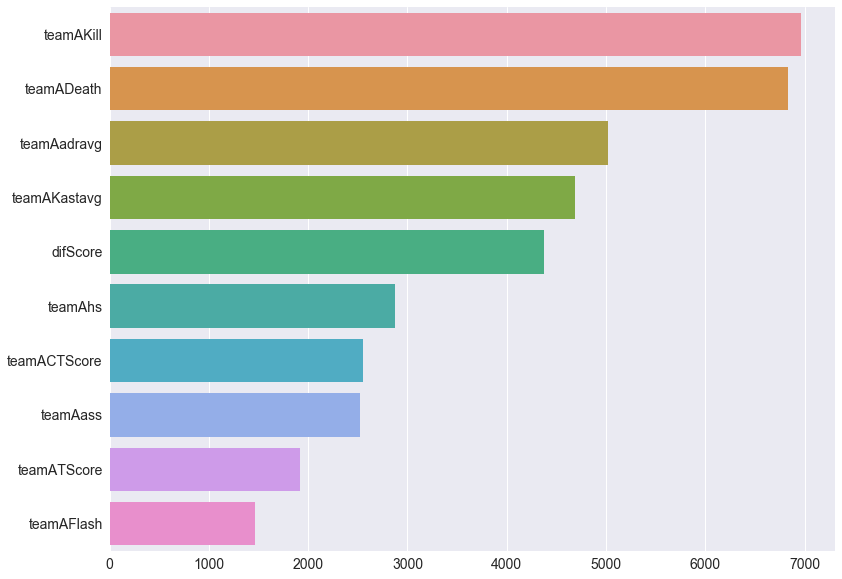

In [16]:
pred_clmns = [
    'difScore', 
    'teamACTScore', 'teamATScore',
    'teamAKill', 'teamAhs',
    'teamADeath', 'teamAass', 'teamAFlash', 
    'teamAadravg', 'teamAKastavg'
]
y_col = 'teamAMatchRating'
cond = mainDf['teamAMatchRating']>0

x_train, x_test, y_train, y_test = preproc_data(mainDf, pred_clmns, y_col, cond=cond)

params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 21,
        'max_bin': 250, 
        'learning_rate': 0.03,
        'feature_fraction': 0.64,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'verbose': 0,
        'n_jobs': 2,
    }

model = fit_model(params, x_train, x_test, y_train, y_test)

fe = pd.Series(model.feature_importance(), index=pred_clmns)
print '\nFEATURE_IMPORTANCE: \n', fe
plot_fe(fe)
# mainDf['teamAMatchRating_pred'] = model.predict(mainDf[pred_clmns])

In [17]:
model.save_model('./models/LGBHLTVMatchRating.model')

In [18]:
mainDf.loc[mainDf['teamAMatchRating']<0, 'teamAMatchRating'] = model.predict(mainDf.loc[mainDf['teamAMatchRating']<0, pred_clmns])
mainDf.loc[np.arange(mainDf.shape[0]/2), 'teamBMatchRating'] = mainDf.loc[np.arange(mainDf.shape[0]/2, mainDf.shape[0]), 'teamAMatchRating'].values
mainDf.loc[np.arange(mainDf.shape[0]/2, mainDf.shape[0]), 'teamBMatchRating'] = mainDf.loc[np.arange(mainDf.shape[0]/2), 'teamAMatchRating'].values

# Predicting MatchRatingMine based on end map statistics. The goal is to go from descrete difScore to continous difScore for further comparison.

In [20]:
dat = matchRating(mainDf)
print dat.shape
dat.head()

0.362999916077
(105604, 304)


,matchlinkId,teamAId,teamBId,map,mapPicker,date,teamAScore,teamBScore,teamACTScore,teamATScore,teamBCTScore,teamBTScore,teamAKill,teamAhs,teamADeath,teamAass,teamAFlash,teamAadravg,teamAKastavg,teamAFirstK,teamAClutch,teamADifuse,teamAExplode,teamBKill,teamBhs,teamBDeath,teamBass,teamBFlash,teamBadravg,teamBKastavg,teamBFirstK,teamBClutch,teamBDifuse,teamBExplode,teamAHalf_0,teamAHalf_1,teamBHalf_0,teamBHalf_1,teamAPistol_half_0,teamAPistol_half_1,teamBPistol_half_0,teamBPistol_half_1,teamAMapLeftToWin,teamBMapLeftToWin,bo,matchFormat,ratingType,teamAMatchRating,teamBMatchRating,matchType,eventId,teamAHalf_0_winStrike_0,teamAHalf_0_looseStrike_0,teamAHalf_1_winStrike_0,teamAHalf_1_looseStrike_0,teamBHalf_0_winStrike_0,teamBHalf_0_looseStrike_0,teamBHalf_1_winStrike_0,teamBHalf_1_looseStrike_0,teamAHalf_0_winStrike_1,teamAHalf_0_looseStrike_1,teamAHalf_1_winStrike_1,teamAHalf_1_looseStrike_1,teamBHalf_0_winStrike_1,teamBHalf_0_looseStrike_1,teamBHalf_1_winStrike_1,teamBHalf_1_looseStrike_1,teamAHalf_0_winStrike_2,teamAHalf_0_looseStrike_2,teamAHalf_1_winStrike_2,teamAHalf_1_looseStrike_2,teamBHalf_0_winStrike_2,teamBHalf_0_looseStrike_2,teamBHalf_1_winStrike_2,teamBHalf_1_looseStrike_2,teamAHalf_0_winStrike_3,teamAHalf_0_looseStrike_3,teamAHalf_1_winStrike_3,teamAHalf_1_looseStrike_3,teamBHalf_0_winStrike_3,teamBHalf_0_looseStrike_3,teamBHalf_1_winStrike_3,teamBHalf_1_looseStrike_3,teamAHalf_0_winStrike_4,teamAHalf_0_looseStrike_4,teamAHalf_1_winStrike_4,teamAHalf_1_looseStrike_4,teamBHalf_0_winStrike_4,teamBHalf_0_looseStrike_4,teamBHalf_1_winStrike_4,teamBHalf_1_looseStrike_4,teamAHalf_0_winStrike_5,teamAHalf_0_looseStrike_5,teamAHalf_1_winStrike_5,teamAHalf_1_looseStrike_5,teamBHalf_0_winStrike_5,teamBHalf_0_looseStrike_5,teamBHalf_1_winStrike_5,teamBHalf_1_looseStrike_5,teamAHalf_0_winStrike_6,teamAHalf_0_looseStrike_6,teamAHalf_1_winStrike_6,teamAHalf_1_looseStrike_6,teamBHalf_0_winStrike_6,teamBHalf_0_looseStrike_6,teamBHalf_1_winStrike_6,teamBHalf_1_looseStrike_6,teamAHalf_0_winStrike_7,teamAHalf_0_looseStrike_7,teamAHalf_1_winStrike_7,teamAHalf_1_looseStrike_7,teamBHalf_0_winStrike_7,teamBHalf_0_looseStrike_7,teamBHalf_1_winStrike_7,teamBHalf_1_looseStrike_7,teamA_half_0_cat0_played,teamA_half_0_cat0_win,teamA_half_0_cat5VScat0_played,teamA_half_0_cat5VScat0_win,teamA_half_0_cat1_played,teamA_half_0_cat1_win,teamA_half_0_cat5VScat1_played,teamA_half_0_cat5VScat1_win,teamA_half_0_cat2_played,teamA_half_0_cat2_win,teamA_half_0_cat5VScat2_played,teamA_half_0_cat5VScat2_win,teamA_half_0_cat3_played,teamA_half_0_cat3_win,teamA_half_0_cat5VScat3_played,teamA_half_0_cat5VScat3_win,teamA_half_0_cat4_played,teamA_half_0_cat4_win,teamA_half_0_cat5VScat4_played,teamA_half_0_cat5VScat4_win,teamA_half_1_cat0_played,teamA_half_1_cat0_win,teamA_half_1_cat5VScat0_played,teamA_half_1_cat5VScat0_win,teamA_half_1_cat1_played,teamA_half_1_cat1_win,teamA_half_1_cat5VScat1_played,teamA_half_1_cat5VScat1_win,teamA_half_1_cat2_played,teamA_half_1_cat2_win,teamA_half_1_cat5VScat2_played,teamA_half_1_cat5VScat2_win,teamA_half_1_cat3_played,teamA_half_1_cat3_win,teamA_half_1_cat5VScat3_played,teamA_half_1_cat5VScat3_win,teamA_half_1_cat4_played,teamA_half_1_cat4_win,teamA_half_1_cat5VScat4_played,teamA_half_1_cat5VScat4_win,teamA_cat0_played,teamA_cat0_win,teamA_cat5VScat0_played,teamA_cat5VScat0_win,teamA_cat1_played,teamA_cat1_win,teamA_cat5VScat1_played,teamA_cat5VScat1_win,teamA_cat2_played,teamA_cat2_win,teamA_cat5VScat2_played,teamA_cat5VScat2_win,teamA_cat3_played,teamA_cat3_win,teamA_cat5VScat3_played,teamA_cat5VScat3_win,teamA_cat4_played,teamA_cat4_win,teamA_cat5VScat4_played,teamA_cat5VScat4_win,teamB_half_0_cat0_played,teamB_half_0_cat0_win,teamB_half_0_cat5VScat0_played,teamB_half_0_cat5VScat0_win,teamB_half_0_cat1_played,teamB_half_0_cat1_win,teamB_half_0_cat5VScat1_played,teamB_half_0_cat5VScat1_win,teamB_half_0_cat2_played,teamB_half_0_cat2_win,teamB_half_0_cat5VScat2_played,teamB_half_0_cat5VScat2_win,teamB_half_0_cat3_played,tea

TRAIN SHAPE: (84483, 12) TEST SHAPE: (21121, 12)

START FITTING:
Training until validation scores don't improve for 25 rounds.
[100]	valid_0's l2: 1.83911	valid_0's l1: 0.976215
[200]	valid_0's l2: 1.56372	valid_0's l1: 0.857024
[300]	valid_0's l2: 1.40755	valid_0's l1: 0.782872
[400]	valid_0's l2: 1.32646	valid_0's l1: 0.739689
[500]	valid_0's l2: 1.27685	valid_0's l1: 0.714626
[600]	valid_0's l2: 1.23699	valid_0's l1: 0.693368
[700]	valid_0's l2: 1.20546	valid_0's l1: 0.674325
[800]	valid_0's l2: 1.17985	valid_0's l1: 0.659933
[900]	valid_0's l2: 1.15791	valid_0's l1: 0.647958
[1000]	valid_0's l2: 1.13919	valid_0's l1: 0.636837
[1100]	valid_0's l2: 1.12832	valid_0's l1: 0.629597
[1200]	valid_0's l2: 1.11867	valid_0's l1: 0.623656
[1300]	valid_0's l2: 1.1078	valid_0's l1: 0.617331
[1400]	valid_0's l2: 1.10044	valid_0's l1: 0.612484
[1500]	valid_0's l2: 1.09324	valid_0's l1: 0.60742
[1600]	valid_0's l2: 1.08902	valid_0's l1: 0.603974
[1700]	valid_0's l2: 1.08679	valid_0's l1: 0.601815


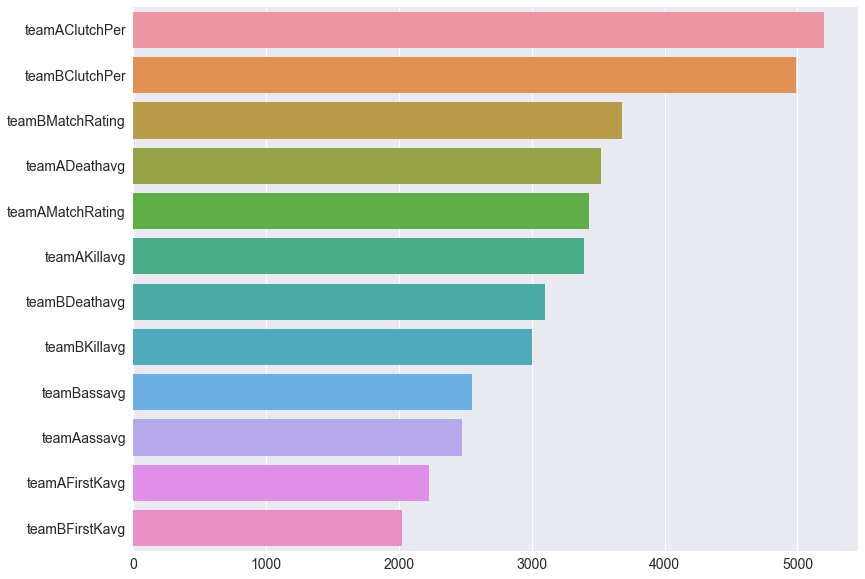

In [21]:
#lgb
pred_clmns = [
#     u'teamATExplodePer', u'teamACTDifusePer',
#               u'teamAExplode', u'teamADifuse', 
#     u'teamAhsPer', u'teamAFlashPer',
              u'teamAKillavg', u'teamADeathavg', u'teamAassavg',
       u'teamAFirstKavg', u'teamAMatchRating', u'teamAClutchPer', 
#        u'teamBTExplodePer', u'teamBCTDifusePer',
#     u'teamBExplode',  u'teamBDifuse',
#     u'teamBhsPer', u'teamBFlashPer', u'ratingType', 
    u'teamBKillavg', u'teamBDeathavg', u'teamBassavg',
       u'teamBFirstKavg', u'teamBMatchRating', u'teamBClutchPer',
]
   
y_col = 'difScore'

x_train, x_test, y_train, y_test = preproc_data(dat, pred_clmns, y_col)

params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 20,
        'learning_rate': 0.1,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'verbose': 0,
        'n_jobs': 2,
    }
model = fit_model(params, x_train, x_test, y_train, y_test)

fe = pd.Series(model.feature_importance(), index=pred_clmns)
print '\nFEATURE_IMPORTANCE: \n', fe
plot_fe(fe)

In [22]:
mainDf['teamAMatchRatingMine'] = model.predict(dat[pred_clmns])
mainDf['teamBMatchRatingMine'] = -100

mainDf.loc[abs(mainDf['teamAMatchRatingMine'] - mainDf['difScore'])>1, 'teamAMatchRatingMine'] = mainDf.loc[abs(mainDf['teamAMatchRatingMine'] - mainDf['difScore'])>1, 'difScore'].values
mainDf['teamAMatchRatingMine'] = np.minimum(np.maximum(mainDf['teamAMatchRatingMine'].values, -16), 16)

mainDf.loc[mainDf.iloc[:mainDf.shape[0]/2].index, 'teamBMatchRatingMine'] = mainDf.loc[mainDf.iloc[mainDf.shape[0]/2:].index, 'teamAMatchRatingMine'].values
mainDf.loc[mainDf.iloc[mainDf.shape[0]/2:].index, 'teamBMatchRatingMine'] = mainDf.loc[mainDf.iloc[:mainDf.shape[0]/2].index, 'teamAMatchRatingMine'].values

In [28]:
model.save_model('./models/LGBMatchRatingMine.model')

In [24]:
teamsRating = pd.read_csv('./data/csgoHLTVRatings.csv', sep=';')
teamsRating['date'] = pd.to_datetime(teamsRating['date']) + dt.timedelta(days=1)
teamsRating.loc[teamsRating['position']==-1, 'position'] = 31
teamsRating['position'] = np.minimum(31, teamsRating['position'])
tm = time.time()
teamsRating['teamavgIncome'] = avgIncome(teamsRating['date'], teamsRating['teamId'], prDistDf[['teamId', 'date', 'win']], 360)
print time.time()-tm

teamsRating.head()

47.3840000629


,teamId,date,rating,position,teamavgIncome
0,6667,2018-04-10,877.0,1,9.250027e+05
1,4494,2018-04-10,810.0,2,5.533906e+05
2,4991,2018-04-10,782.0,3,1.136768e+06
3,6665,2018-04-10,651.0,4,3.309171e+05
4,4608,2018-04-10,615.0,5,1.690281e+05


In [25]:
mainDf[mainDf['teamAMatchRating']<=0].shape #632

(0, 306)

In [36]:
mainDf['date'].dtype, teamsRating['date'].dtype

(dtype('<M8[ns]'), dtype('<M8[ns]'))

# Расчет статистик по прошедшим матча за последние 2 месяца для последующго предсказания HLTV рейтингов

In [29]:
lcldf = teamRatingsPastTwoMonthsGameStats(teamsRating, mainDf)
lcldf.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000


,validGameDifscoreSum,validGameDifscoreWin,validGameDifscoreMean,validGameadrMean,validGamePerfomMean,validGamePerfomWinMean,validGamePerfomLooseMean,validGameDifscoreSumEnemy,validGameDifscoreWinEnemy,validGameDifscoreMeanEnemy,validGameadrMeanEnemy,validGamePerfomMeanEnemy,validGamePerfomWinMeanEnemy,validGamePerfomLooseMeanEnemy,validGameDifscoreSumNet,validGameDifscoreWinNet,validGameDifscoreMeanNet,validGameadrMeanNet,validGamePerfomMeanNet,validGamePerfomWinMeanNet,validGamePerfomLooseMeanNet,validGameDifscoreSumMine,validGameDifscoreWinMine,validGameDifscoreMeanMine,validGameadrMeanMine,validGamePerfomMeanMine,validGamePerfomWinMeanMine,validGamePerfomLooseMeanMine
0,112,0.562500,1.750000,76.420312,1.107031,1.292778,0.868214,63,0.733333,4.200000,80.837333,1.186000,1.301818,0.867500,23,0.485714,0.657143,74.821143,1.066000,1.268824,0.874444,26,0.571429,1.857143,75.685714,1.125000,1.331250,0.850
1,97,0.621212,1.469697,76.268182,1.108182,1.236341,0.898000,-14,0.538462,-1.076923,73.778462,1.035385,1.234286,0.803333,57,0.585366,1.390244,76.281463,1.101220,1.230000,0.919412,54,0.833333,4.500000,78.920000,1.210833,1.253000,1.000
2,87,0.593750,1.359375,78.165313,1.100156,1.254474,0.874615,18,0.571429,1.285714,79.945714,1.127857,1.326250,0.863333,27,0.583333,0.750000,76.546111,1.063611,1.220952,0.843333,42,0.642857,3.000000,80.548571,1.166429,1.268889,0.982
3,218,0.745763,3.694915,79.068136,1.178136,1.264773,0.924000,26,0.636364,2.363636,76.020000,1.125455,1.235714,0.932500,142,0.756757,3.837838,79.712432,1.184595,1.272500,0.911111,50,0.818182,4.545455,79.949091,1.209091,1.263333,0.965
4,60,0.580000,1.200000,77.002400,1.114800,1.261034,0.912857,-12,0.416667,-1.000000,74.136667,1.039167,1.184000,0.935714,71,0.653846,2.730769,78.777692,1.170385,1.297647,0.930000,1,0.583333,0.083333,76.021667,1.070000,1.227143,0.850


In [30]:
ttt = pd.concat([teamsRating, lcldf], axis=1)

In [31]:
ttt.to_csv('./data/teamHLTVRatingPostDF.csv', sep=';', index=False)

In [32]:
ttt = pd.read_csv('./data/teamHLTVRatingPostDF.csv', sep=';')
ttt['date'] = pd.to_datetime(ttt['date'])
ttt.loc[ttt['position']==-1, 'position'] = 31
ttt['position'] = np.minimum(31, ttt['position'])
ttt.fillna(0, inplace=True)
ttt.head()

,teamId,date,rating,position,teamavgIncome,validGameDifscoreSum,validGameDifscoreWin,validGameDifscoreMean,validGameadrMean,validGamePerfomMean,validGamePerfomWinMean,validGamePerfomLooseMean,validGameDifscoreSumEnemy,validGameDifscoreWinEnemy,validGameDifscoreMeanEnemy,validGameadrMeanEnemy,validGamePerfomMeanEnemy,validGamePerfomWinMeanEnemy,validGamePerfomLooseMeanEnemy,validGameDifscoreSumNet,validGameDifscoreWinNet,validGameDifscoreMeanNet,validGameadrMeanNet,validGamePerfomMeanNet,validGamePerfomWinMeanNet,validGamePerfomLooseMeanNet,validGameDifscoreSumMine,validGameDifscoreWinMine,validGameDifscoreMeanMine,validGameadrMeanMine,validGamePerfomMeanMine,validGamePerfomWinMeanMine,validGamePerfomLooseMeanMine
0,6667,2018-04-10,877.0,1,9.250027e+05,112,0.562500,1.750000,76.420312,1.107031,1.292778,0.868214,63,0.733333,4.200000,80.837333,1.186000,1.301818,0.867500,23,0.485714,0.657143,74.821143,1.066000,1.268824,0.874444,26,0.571429,1.857143,75.685714,1.125000,1.331250,0.850
1,4494,2018-04-10,810.0,2,5.533906e+05,97,0.621212,1.469697,76.268182,1.108182,1.236341,0.898000,-14,0.538462,-1.076923,73.778462,1.035385,1.234286,0.803333,57,0.585366,1.390244,76.281463,1.101220,1.230000,0.919412,54,0.833333,4.500000,78.920000,1.210833,1.253000,1.000
2,4991,2018-04-10,782.0,3,1.136768e+06,87,0.593750,1.359375,78.165313,1.100156,1.254474,0.874615,18,0.571429,1.285714,79.945714,1.127857,1.326250,0.863333,27,0.583333,0.750000,76.546111,1.063611,1.220952,0.843333,42,0.642857,3.000000,80.548571,1.166429,1.268889,0.982
3,6665,2018-04-10,651.0,4,3.309171e+05,218,0.745763,3.694915,79.068136,1.178136,1.264773,0.924000,26,0.636364,2.363636,76.020000,1.125455,1.235714,0.932500,142,0.756757,3.837838,79.712432,1.184595,1.272500,0.911111,50,0.818182,4.545455,79.949091,1.209091,1.263333,0.965
4,4608,2018-04-10,615.0,5,1.690281e+05,60,0.580000,1.200000,77.002400,1.114800,1.261034,0.912857,-12,0.416667,-1.000000,74.136667,1.039167,1.184000,0.935714,71,0.653846,2.730769,78.777692,1.170385,1.297647,0.930000,1,0.583333,0.083333,76.021667,1.070000,1.227143,0.850


# Predicting HLTV ratings

In [34]:
clmns = ttt.columns[3:]
cond = ttt['date']>='2016-06-01'
x_tr, x_te, y_tr, y_te = train_test_split(ttt[cond][clmns], ttt[cond]['rating'], train_size=0.7, random_state=254)
clmns


Index([u'position', u'teamavgIncome', u'validGameDifscoreSum',
       u'validGameDifscoreWin', u'validGameDifscoreMean', u'validGameadrMean',
       u'validGamePerfomMean', u'validGamePerfomWinMean',
       u'validGamePerfomLooseMean', u'validGameDifscoreSumEnemy',
       u'validGameDifscoreWinEnemy', u'validGameDifscoreMeanEnemy',
       u'validGameadrMeanEnemy', u'validGamePerfomMeanEnemy',
       u'validGamePerfomWinMeanEnemy', u'validGamePerfomLooseMeanEnemy',
       u'validGameDifscoreSumNet', u'validGameDifscoreWinNet',
       u'validGameDifscoreMeanNet', u'validGameadrMeanNet',
       u'validGamePerfomMeanNet', u'validGamePerfomWinMeanNet',
       u'validGamePerfomLooseMeanNet', u'validGameDifscoreSumMine',
       u'validGameDifscoreWinMine', u'validGameDifscoreMeanMine',
       u'validGameadrMeanMine', u'validGamePerfomMeanMine',
       u'validGamePerfomWinMeanMine', u'validGamePerfomLooseMeanMine'],
      dtype='object')

In [35]:
lgb_train = lgb.Dataset(x_tr, y_tr)
lgb_eval = lgb.Dataset(x_te, y_te)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 30,
    'max_bin': 30,
#     'max_depth': 7,
    'learning_rate': 0.02,
    'feature_fraction': 0.64,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'n_threads': 2
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets = [lgb_eval, lgb_train],
                valid_names = ['eval', 'train'],
                early_stopping_rounds=10, verbose_eval=100)

y_tr_pred = gbm.predict(x_tr, num_iteration=gbm.best_iteration)
y_te_pred = gbm.predict(x_te, num_iteration=gbm.best_iteration)

print 'TRAIN', 'MAE', mean_absolute_error(y_tr_pred, y_tr), 'RMSE', mean_squared_error(y_tr_pred, y_tr)**0.5
print 'TEST', 'MAE', mean_absolute_error(y_te_pred, y_te), 'RMSE', mean_squared_error(y_te_pred, y_te)**0.5

gbm.save_model('./models/LGBHLTVRatingPrediction.model')

ttt.loc[cond, 'pred_rating'] = np.maximum(np.minimum(gbm.predict(ttt[cond][clmns]), 1000), 0)

Starting training...
Training until validation scores don't improve for 10 rounds.
[100]	train's l2: 584.109	train's l1: 10.7585	eval's l2: 722.636	eval's l1: 11.2206
[200]	train's l2: 189.846	train's l1: 6.70164	eval's l2: 299.534	eval's l1: 7.46725
[300]	train's l2: 136.811	train's l1: 5.91628	eval's l2: 257.41	eval's l1: 6.86083
[400]	train's l2: 112.905	train's l1: 5.55221	eval's l2: 244.26	eval's l1: 6.65018
[500]	train's l2: 97.521	train's l1: 5.29317	eval's l2: 236.779	eval's l1: 6.52472
[600]	train's l2: 86.0549	train's l1: 5.07971	eval's l2: 231.756	eval's l1: 6.42724
[700]	train's l2: 77.2134	train's l1: 4.90293	eval's l2: 228.164	eval's l1: 6.3594
[800]	train's l2: 70.4573	train's l1: 4.74325	eval's l2: 225.454	eval's l1: 6.2925
[900]	train's l2: 64.9122	train's l1: 4.60438	eval's l2: 223.526	eval's l1: 6.2403
[1000]	train's l2: 59.9589	train's l1: 4.47888	eval's l2: 220.992	eval's l1: 6.19091
Did not meet early stopping. Best iteration is:
[1000]	train's l2: 59.9589	train's

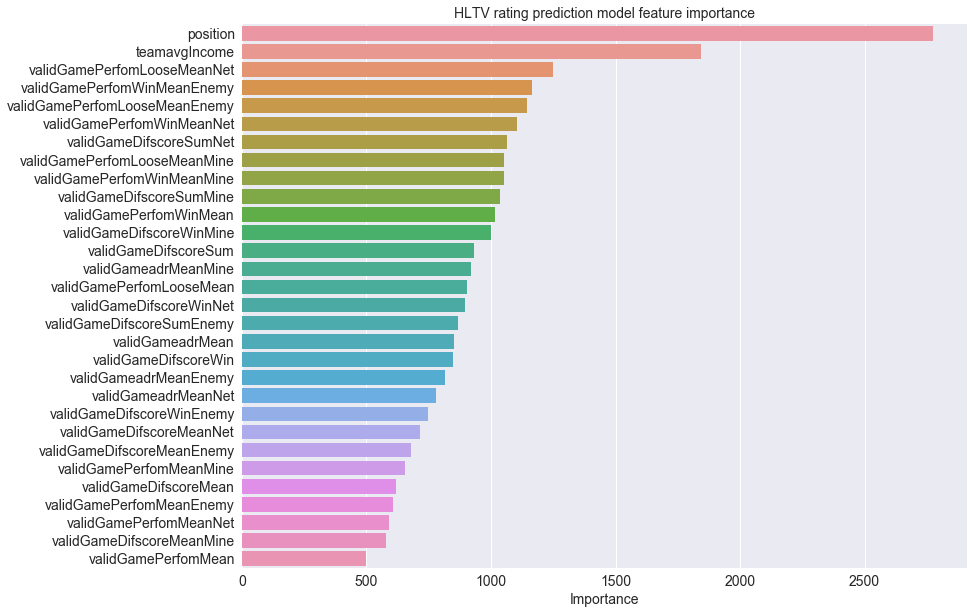

In [36]:
_ = pd.Series(gbm.feature_importance(), index=clmns).sort_values(ascending=False)

plt.figure(figsize=(13, 10));
font_size = 14
sns.set(font_scale=font_size/10.0)
ax = sns.barplot(x=_.values.reshape(1, -1)[0], y=_.index);
ax.set_xlabel('Importance', fontsize=font_size)
# ax.set_ylabel('Feature', fontsize=font_size)
ax.set_title('HLTV rating prediction model feature importance', fontsize=font_size)
plt.show()

In [ ]:
# fix min(31, position) for every match in MAINDF
mainDf = hltWeekRatingvPositionPropogation(mainDf, ttt)

In [38]:
# CALCULATE STATS FOR EVERY MATCH IN MAINDF FOR HLTV RATING PREDICTION
lcldf2 = pd.DataFrame()
lcldf2['position'] = mainDf['teamAPosition'].values
lcldf2['teamavgIncome'] = mainDf['teamAavgIncome'].values
lcldf2 = pd.concat([lcldf2, teamRatingsPastTwoMonthsGameStats(mainDf, mainDf, 'teamAId')], axis=1)
# nan appears due to division on 0 in teamRatingsPastTwoMonthsGameStats
lcldf2.fillna(0, inplace=True)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000


In [39]:
# PREDICT HLTV RATINGS
mainDf['ratingA_HLTV'] = np.maximum(np.minimum(gbm.predict(lcldf2[clmns]), 1000), 0)
mainDf['ratingB_HLTV'] = 0
mainDf.loc[mainDf.iloc[:mainDf.shape[0]/2].index, 'ratingB_HLTV'] = mainDf.loc[mainDf.iloc[mainDf.shape[0]/2:].index, 'ratingA_HLTV'].values
mainDf.loc[mainDf.iloc[mainDf.shape[0]/2:].index, 'ratingB_HLTV'] = mainDf.loc[mainDf.iloc[:mainDf.shape[0]/2].index, 'ratingA_HLTV'].values
mainDf.shape, mainDf.loc[mainDf.shape[0]/2:, 'ratingA_HLTV'].shape

((105604, 309), (52802L,))

In [43]:
mainDf.to_csv('./data/preprocessedMAIN.csv', sep=';', index=False)

In [4]:
mainDf = pd.read_csv('./data/preprocessedMAIN.csv', sep=';')
# mainDf.rename({'teamAHLTVRating': 'ratingA_HLTV', 'teamBHLTVRating': 'ratingB_HLTV'}, axis=1, inplace=True)

rating Systems accuracy: ['elo0' 'elo0Inf' 'trueskillUnrate' 'trueskill' 'glicko2' 'HLTV' 'glicko'] => [0.62865 0.62261 0.60125 0.60111 0.59973 0.59339 0.57413]


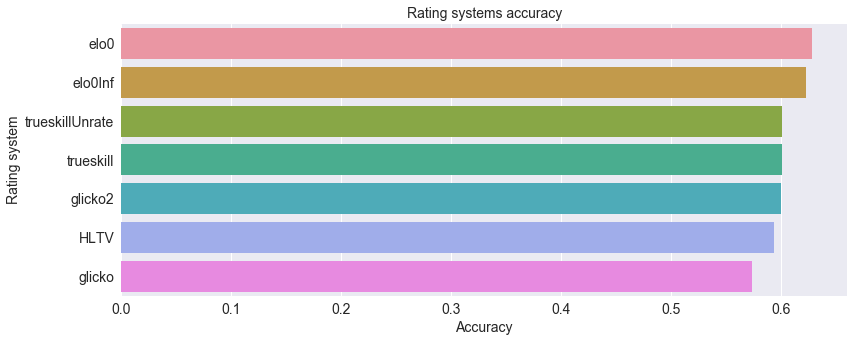

In [42]:
index = []
values = []
for i in ['HLTV'] + [''.join(filename.split('.')[0].split('Rating')) for filename in os.listdir('./CSGO_ratings_prediction/') if 'csv' in filename]:
    index += [i]
    values += [sum(((mainDf['ratingA_%s'%i]>mainDf['ratingB_%s'%i]) & (mainDf['difScore']>0)) | ((mainDf[u'ratingA_%s'%i]<mainDf[u'ratingB_%s'%i]) & (mainDf['difScore']<0)))/float(mainDf.shape[0])]
    
_ = pd.Series(values, index=index).sort_values(ascending=False)
print 'rating Systems accuracy:', _.index.values, '=>', np.round(_.values, 5)

plt.figure(figsize=(13, 5));
font_size = 14
sns.set(font_scale=font_size/10.0)
ax = sns.barplot(x=_.values, y=_.index.values)
ax.set_xlabel('Accuracy', fontsize=font_size)
ax.set_ylabel('Rating system', fontsize=font_size)
ax.set_title('Rating systems accuracy', fontsize=font_size)
plt.show()

In [44]:
newMainDf = mainDf.copy()

In [824]:
newMainDf.columns.values

array(['matchlinkId', 'teamAId', 'teamBId', 'map', 'mapPicker', 'date',
       'teamAScore', 'teamBScore', 'teamACTScore', 'teamATScore',
       'teamBCTScore', 'teamBTScore', 'teamAKill', 'teamAhs',
       'teamADeath', 'teamAass', 'teamAFlash', 'teamAadravg',
       'teamAKastavg', 'teamAFirstK', 'teamAClutch', 'teamADifuse',
       'teamAExplode', 'teamBKill', 'teamBhs', 'teamBDeath', 'teamBass',
       'teamBFlash', 'teamBadravg', 'teamBKastavg', 'teamBFirstK',
       'teamBClutch', 'teamBDifuse', 'teamBExplode', 'teamAHalf_0',
       'teamAHalf_1', 'teamBHalf_0', 'teamBHalf_1', 'teamAPistol_half_0',
       'teamAPistol_half_1', 'teamBPistol_half_0', 'teamBPistol_half_1',
       'teamAMapLeftToWin', 'teamBMapLeftToWin', 'bo', 'matchFormat',
       'ratingType', 'teamAMatchRating', 'teamBMatchRating', 'matchType',
       'eventId', 'teamAHalf_0_winStrike_0', 'teamAHalf_0_looseStrike_0',
       'teamAHalf_1_winStrike_0', 'teamAHalf_1_looseStrike_0',
       'teamBHalf_0_winStrike_0', 

In [49]:
cls = ['matchlinkId', 'teamAId', 'teamBId', 'map', 'mapPicker', 'date',
       'teamAScore', 'teamBScore', 'teamACTScore', 'teamATScore',
       'teamBCTScore', 'teamBTScore', 'teamAKill', 'teamAhs',
       'teamADeath', 'teamAass', 'teamAFlash', 'teamAadravg',
       'teamAKastavg', 'teamAFirstK', 'teamAClutch', 'teamADifuse',
       'teamAExplode', 'teamBKill', 'teamBhs', 'teamBDeath', 'teamBass',
       'teamBFlash', 'teamBadravg', 'teamBKastavg', 'teamBFirstK',
       'teamBClutch', 'teamBDifuse', 'teamBExplode', 'teamAHalf_0',
       'teamAHalf_1', 'teamBHalf_0', 'teamBHalf_1', 'teamAPistol_half_0',
       'teamAPistol_half_1', 'teamBPistol_half_0', 'teamBPistol_half_1',
       'teamAMapLeftToWin', 'teamBMapLeftToWin', 'bo', 'matchFormat',
       'ratingType', 'teamAMatchRating', 'teamBMatchRating', 'matchType',] + [i for i in mainDf.columns.values if 'cat' in i] + ['isMainEvent', 'teamAfirPlaceRatio',
       'teamBfirPlaceRatio', 'teamAmaxPrPoolRatio', 'teamBmaxPrPoolRatio',
       'teamAavgIncomeNull', 'teamBavgIncomeNull', 'avgIncomeDif',
       'maxPrPoolRatioDif', 'firPlaceRatioDif', 'teamAMatchRatingMine',
       'teamBMatchRatingMine', 'teamATExplodePer', 'teamACTDifusePer',
       'teamBTExplodePer', 'teamBCTDifusePer', 'teamAKillavg',
       'teamADeathavg', 'teamAassavg', 'teamAFirstKavg', 'teamBKillavg',
       'teamBDeathavg', 'teamBassavg', 'teamBFirstKavg', 'teamAClutchPer',
       'teamBClutchPer', 'teamAhsPer', 'teamAFlashPer', 'teamBhsPer',
       'teamBFlashPer']

mainDf[cls].to_csv('./data/COMMONDATA.csv', index=False)

In [45]:
prefixes = [''.join(filename.split('.')[0].split('Rating')) for filename in os.listdir('./CSGO_ratings_prediction/') if 'csv' in filename]
prefixes = ['HLTV'] + prefixes
prefixes

['HLTV',
 'elo0',
 'elo0Inf',
 'glicko',
 'glicko2',
 'trueskill',
 'trueskillUnrate']

In [46]:
# %autoreload 2
# c учетом карт
n_neighbors = 1000
mps = [u'Mirage', u'Train', 'Cache', u'Cobblestone', u'Dust2', u'Inferno', u'Nuke', u'Overpass']
mapK = {mp: [int(n_neighbors*mainDf[mainDf['map']==mp].shape[0]/float(mainDf.shape[0])), ''] for mp in mps}
days = 28
print mapK
isCorr = 'corr'
isCorr = 'lr'

for prefix in prefixes:
    
#     prefix = 'elo0'
    tm = time.time()
    print prefix
    if 'glicko' in prefix:
        continue
#     if 'hange' in prefix:# or 'elo' in prefix:
#         continue
    newMainDf = mainDf.copy()
    newMainDf['date'] = pd.to_datetime(newMainDf['date'])
#     newMainDf.drop(newMainDf[newMainDf['teamAKillavg']>1].index, inplace=True)
#     newMainDf.drop(newMainDf[newMainDf['teamBKillavg']>1].index, inplace=True)
#     newMainDf['teamAadravg'] = newMainDf['teamAadravg'].values/100.0
#     newMainDf['teamBadravg'] = newMainDf['teamBadravg'].values/100.0
    newMainDf.reset_index(drop=True, inplace=True)
    
    print 'preproc'
    newMainDf = preproc(newMainDf, ['ratingA_%s'%prefix, 'ratingB_%s'%prefix])
    if prefix=='HLTV':
#         continue
        newMainDf['ratingDif'] = np.power(newMainDf['ratingA_%s'%prefix], 0.3) - np.power(newMainDf['ratingB_%s'%prefix], 0.3)
        
    print 'createScaledDf'
    newMainDfScaled, scaler = createScaledDf(newMainDf, StandardScaler())
    joblib.dump(scaler, './rating_systems/%s/scaler1'%(prefix))

    print 'scale'
    clmns = [#'ratingA_%s'%prefix, 'ratingB_%s'%prefix, 
             'ratingDif']
#     print newMainDf[newMainDf[clmns].isnull().any(axis=1)].head()
    ttt, scaler = scale(newMainDf, clmns, StandardScaler())
    newMainDfScaled = pd.concat([newMainDfScaled, ttt], axis=1)
    joblib.dump(scaler, './rating_systems/%s/scaler2'%(prefix))

    print 'corralationMultiplier'
    tmpInd = newMainDf[newMainDf['difScore']>=-16].index
    if isCorr=='corr':
        print 'correlation multiplier'
        difclmns = [#'ratingA_%s'%prefix, 'ratingB_%s'%prefix, 
                    'ratingDif']
        clmns = difclmns + [
#             'teamAMapLeftToWin', 'teamBMapLeftToWin',
#                'teamAavgIncome', 'teamBavgIncome', 
               'teamAfirPlaceRatio', 'teamBfirPlaceRatio', 
#             'teamAmaxPrPoolRatio', 'teamBmaxPrPoolRatio', 
            'teamAMatchRatingMine', 'teamBMatchRatingMine',
#                 u'matchFormat_0', u'matchFormat_1', u'matchFormat_2',
#                 u'mapPicker_-1', u'mapPicker_0', u'mapPicker_1',
               ]
        newMainDfScaled, corr, corrMean = corralationMultiplier(newMainDfScaled, clmns, difclmns, tmpInd)
#         with open('./%s_%s_%scopy/%s/coor.csv'%(str(isCorr), str(n_neighbors), str(days), prefix), 'w') as f:
#             corr.to_csv(f, sep=';')
#         with open('./%s_%s_%scopy/%s/conf.txt'%(str(isCorr), str(n_neighbors), str(days), prefix), 'w') as f:
#             f.write('%s\n'%str(corrMean))
        print 'corrMean', corrMean
        print 'corr', corr
    elif isCorr=='lr':
        newMainDfScaled['difScore'] = newMainDf['difScore'].values
        print 'LINEAR_REGRESSION multiplier'
        pred_clmns = [#'ratingA_%s'%prefix, 'ratingB_%s'%prefix, 
                     'ratingDif',
        #              u'teamAMapLeftToWin', u'teamBMapLeftToWin',
        #              u'teamAavgIncome', u'teamBavgIncome', 
                     u'teamAfirPlaceRatio', u'teamBfirPlaceRatio', 
#                      u'teamAmaxPrPoolRatio', u'teamBmaxPrPoolRatio',
                     u'matchType',
                     u'matchFormat_0', u'matchFormat_1', u'matchFormat_2',
                     u'mapPicker_-1', u'mapPicker_0', u'mapPicker_1']

        y_col = 'difScore'

        x_train, x_test, y_train, y_test = preproc_data(newMainDfScaled, pred_clmns, y_col)

        params = {
        }

        model = fit_model(params, x_train, x_test, y_train, y_test, modelname='lr')
        print model.coef_
        joblib.dump(model, './rating_systems/%s/preKNNLinearRegCoefModel'%(prefix))
        newMainDfScaled[pred_clmns] = newMainDfScaled[pred_clmns].values * abs(model.coef_)

# model.coef_
        
    newMainDfScaled['teamAMatchRating'] = newMainDf['teamAMatchRating'].values
    newMainDfScaled['teamBMatchRating'] = newMainDf['teamBMatchRating'].values
    
#     print newMainDfScaled.describe()
#     assert False
    print 'fitKNN'
    clmns = [#'ratingA_%s'%prefix, 'ratingB_%s'%prefix, 
             'ratingDif',
#              u'teamAMapLeftToWin', u'teamBMapLeftToWin',
#              u'teamAavgIncome', u'teamBavgIncome', 
             u'teamAfirPlaceRatio', u'teamBfirPlaceRatio', 
#              u'teamAmaxPrPoolRatio', u'teamBmaxPrPoolRatio',
             u'matchType',
             u'matchFormat_0', u'matchFormat_1', u'matchFormat_2',
             u'mapPicker_-1', u'mapPicker_0', u'mapPicker_1']
    
        
    knnS = [
                        [newMainDf['difScore']>=-16, 'force'],
            ]
    iterateClmns = [
                        [
#                         ('teamARForceWeighted', 'teamAMatchRatingMine'), 
                            ('teamARForce', 'teamAMatchRatingMine'), 
#                         ('teamARForceHLTVWeighted', 'teamAMatchRating'), 
                            ('teamARForceHLTV', 'teamAMatchRating')
                        ], 
                   ]
    
    print '#fitKnn and global relativeForceCalculation'
    for index, value in enumerate(knnS):
        knn = fitKNN(newMainDfScaled.loc[value[0], clmns].values, n_neighbors)
        joblib.dump(knn, './rating_systems/%s/knn%s'%(prefix, value[1]))
        knnS[index].append(knn)
        newMainDf = relativeForceCalculation(newMainDf, newMainDfScaled, knn, clmns, iterateClmns[index], value[0], 1)
        
#     newMainDf = relativeForceCalculation(newMainDf, newMainDfScaled, knn, clmns, tmpInd, 1)
#     print newMainDf[['teamARelativeForce', 'teamARelativeForceWeighted','teamBRelativeForce', 'teamBRelativeForceWeighted']].info()
#     assert False
    print 'relativeForceHistoryCalculation'
    
    iterateHistoryClmns = [
                    ('teamARHForce', 'teamARForce', False), 
                    ('teamARHForceW', 'teamARForce', True), 
#                     ('teamARHForceWeighted', 'teamARForceWeighted', False), 
#                     ('teamARHForceWeightedW', 'teamARForceWeighted', True),
                    ('teamARHForceHLTV', 'teamARForceHLTV', False), 
                    ('teamARHForceHLTVW', 'teamARForceHLTV', True), 
#                     ('teamARHForceWeighted', 'teamARForceHLTVWeighted', False), 
#                     ('teamARHForceHLTVWeightedW', 'teamARForceHLTVWeighted', True),
                    ]
    newMainDf = relativeForceHistoryCalculation(newMainDf, days, iterateHistoryClmns)
    print 'relativeForceCalculation'
    
    iterateHistoryClmns = [
                    ('teamARHForceSpec', 'teamARForceSpec', False), 
                    ('teamARHForceSpecW', 'teamARForceSpec', True), 
#                     ('teamARHForceWeightedSpec', 'teamARForceWeightedSpec', False), 
#                     ('teamARHForceWeightedSpecW', 'teamARForceWeightedSpec', True),
                    ('teamARHForceHLTVSpec', 'teamARForceHLTVSpec', False), 
                    ('teamARHForceHLTVSpecW', 'teamARForceHLTVSpec', True), 
#                     ('teamARHForceWeightedSpec', 'teamARForceWeightedSpec', False), 
#                     ('teamARHForceHLTVWeightedSpecW', 'teamARForceHLTVWeightedSpec', True),
                    ]
    for mp in mps:
        print mp
        for index, value  in enumerate(knnS):
            print value[1]
            mapIndex = newMainDfScaled.loc[value[0]][newMainDfScaled.loc[value[0], 'map']==mp].index
    #         print newMainDfScaled.loc[mapIndex, clmns].info()
#             mapK[mp][1] = fitKNN(newMainDfScaled.loc[mapIndex, clmns].values, mapK[mp][0])#localknn
            mapKnn = fitKNN(newMainDfScaled.loc[mapIndex, clmns].values, max(100, mapK[mp][0]))#localknn
            joblib.dump(mapKnn, './rating_systems/%s/knn%s%s'%(prefix, mp, value[1]))
            knnS[index].append(mapKnn)
    #         print 'herh'
    #         newMainDfScaled.info()
    #         assert False
            iterateSpecClmns = [(j[0]+'Spec', j[1]) for j in iterateClmns[index]]
            newMainDf = relativeForceCalculation(newMainDf, newMainDfScaled, mapKnn, clmns, iterateSpecClmns, mapIndex)
#         print 'herh'
        print 'local relativeForceHistoryCalculation'
        mapIndexAll = newMainDfScaled[newMainDfScaled['map']==mp].index
        newMainDf = relativeForceHistoryCalculation(newMainDf, days, iterateHistoryClmns, mapIndexAll)
        
    print 'noHistoryDefine'
    
    iterateNoHistClmns = [
#                     ('teamARNOHForce', 'teamARHForce', 'teamARHForceWeighted', 'teamARHForceW', 'teamARHForceWeightedW', 0.5),
#                     ('teamBRNOHForce', 'teamBRHForce', 'teamBRHForceWeighted', 'teamBRHForceW', 'teamBRHForceWeightedW', 0.5),
#                     ('teamARNOHForce', 'teamARHForceW', 'teamARHForceWeightedW', 'teamARHForceHLTVW', 'teamARHForceHLTVWeightedW', 'teamA_n_last_maps', 0.5),
#                     ('teamBRNOHForce', 'teamBRHForceW', 'teamBRHForceWeightedW', 'teamBRHForceHLTVW', 'teamBRHForceHLTVWeightedW', 'teamB_n_last_maps', 0.5),
                    ('teamARNOHForce', 'teamARHForceW', 'teamARHForce', 'teamARHForceHLTVW', 'teamARHForceHLTV', 'teamA_n_last_maps', 0.5),
                    ('teamBRNOHForce', 'teamBRHForceW', 'teamBRHForce', 'teamBRHForceHLTVW', 'teamBRHForceHLTV', 'teamB_n_last_maps', 0.5),
                    
#                     ('teamARNOHForceSpec', 'teamARHForceSpec', 'teamARHForceWeightedSpec', 'teamARHForceSpecW', 'teamARHForceWeightedSpecW', 0.5),
#                     ('teamBRNOHForceSpec', 'teamBRHForceSpec', 'teamBRHForceWeightedSpec', 'teamBRHForceSpecW', 'teamBRHForceWeightedSpecW',0.5),
#                     ('teamARNOHForceSpec', 'teamARHForceSpecW', 'teamARHForceWeightedSpecW', 'teamARHForceHLTVSpecW', 'teamARHForceHLTVWeightedSpecW', 'teamA_n_last_mapsSpec', 0.5),
#                     ('teamBRNOHForceSpec', 'teamBRHForceSpecW', 'teamBRHForceWeightedSpecW', 'teamBRHForceHLTVSpecW', 'teamBRHForceHLTVWeightedSpecW', 'teamA_n_last_mapsSpec', 0.5),
                    ('teamARNOHForceSpec', 'teamARHForceSpecW', 'teamARHForceSpec', 'teamARHForceHLTVSpecW', 'teamARHForceHLTVSpec', 'teamA_n_last_mapsSpec', 0.5),
                    ('teamBRNOHForceSpec', 'teamBRHForceSpecW', 'teamBRHForceSpec', 'teamBRHForceHLTVSpecW', 'teamBRHForceHLTVSpec', 'teamA_n_last_mapsSpec', 0.5),
                    
                    ]
    newMainDf = noHistoryDefine(newMainDf, iterateNoHistClmns)
    
#     RHCols = ['teamARHForce', 'teamARHForceWeighted', 'teamARHForceW', 'teamARHForceWeightedW', 'teamBRHForce', 'teamBRHForceWeighted', 'teamBRHForceW', 'teamBRHForceWeightedW',
#              'teamARHForceSpec', 'teamARHForceWeightedSpec', 'teamARHForceSpecW', 'teamARHForceWeightedSpecW', 'teamBRHForceSpec', 'teamBRHForceWeightedSpec', 'teamBRHForceSpecW', 'teamBRHForceWeightedSpecW']
#     RHCols = [
#              'teamARHForceW', 'teamARHForceWeightedW', 'teamBRHForceW', 'teamBRHForceWeightedW',
#              'teamARHForceSpecW', 'teamARHForceWeightedSpecW','teamBRHForceSpecW', 'teamBRHForceWeightedSpecW',
#              'teamARHForceHLTVW', 'teamARHForceHLTVWeightedW', 'teamBRHForceHLTVW', 'teamBRHForceHLTVWeightedW',
#              'teamARHForceHLTVSpecW', 'teamARHForceHLTVWeightedSpecW','teamBRHForceHLTVSpecW', 'teamBRHForceHLTVWeightedSpecW'
#              ]
    RHCols = [
             'teamARHForce', 'teamARHForceW', 'teamBRHForce', 'teamBRHForceW',
             'teamARHForceSpec', 'teamARHForceSpecW','teamBRHForceSpec', 'teamBRHForceSpecW',
             'teamARHForceHLTV', 'teamARHForceHLTVW', 'teamBRHForceHLTV', 'teamBRHForceHLTVW',
             'teamARHForceHLTVSpec', 'teamARHForceHLTVSpecW','teamBRHForceHLTVSpec', 'teamBRHForceHLTVSpecW'
             ]
    RHRDCols = [i+'RD' for i in RHCols]
#     assert False
    print 'absoluteForceCalculation'

    iterateSpecClmns = [[
                        ('teamAabsForceSpec', 'teamARHForceSpec', 'teamAMatchRatingMine'), 
                        ('teamAabsForceSpecW', 'teamARHForceSpecW', 'teamAMatchRatingMine'), 
#                         ('teamAabsForceWeightedSpec', 'teamARHForceWeightedSpec', 'teamAMatchRatingMine'), 
#                         ('teamAabsForceWeightedSpecW', 'teamARHForceWeightedSpecW', 'teamAMatchRatingMine'),
                        ('teamAabsForceHLTVSpec', 'teamARHForceHLTVSpec', 'teamAMatchRating'), 
                        ('teamAabsForceHLTVSpecW', 'teamARHForceHLTVSpecW', 'teamAMatchRating'), 
#                         ('teamAabsForceWeightedSpec', 'teamARHForceWeightedSpec', 'teamAMatchRating'), 
#                         ('teamAabsForceHLTVWeightedSpecW', 'teamARHForceHLTVWeightedSpecW', 'teamAMatchRating'),
                        ]]
    for cnt, mp in enumerate(mps):
        print mp
        for index, value in enumerate(knnS):
            print value[1]
            mapIndex = newMainDfScaled.loc[value[0]][newMainDfScaled.loc[value[0], 'map']==mp].index.values
            mapIndexAll = newMainDfScaled[newMainDfScaled['map']==mp].index.values
            newMainDf = absoluteForceCalculation(newMainDf, newMainDfScaled, knnS[index][cnt+3], clmns, iterateSpecClmns[index], mapIndexAll, mapIndex)

            mapIndexAll = newMainDfScaled[(newMainDfScaled['map']==mp) & (value[0])].index
            newMainDf = probForceCalculation(newMainDf, newMainDfScaled, knnS[index][cnt+3], clmns, iterateSpecClmns[index], mapIndexAll, mapIndex)
            mapIndexAll = newMainDfScaled[(newMainDfScaled['map']==mp) & (~value[0])].index
            newMainDf = probForceCalculation(newMainDf, newMainDfScaled, knnS[index][cnt+3], clmns, iterateSpecClmns[index], mapIndexAll, mapIndex)
#         newMainDf = probForceCalculation(newMainDf, newMainDfScaled, mapK[mp][1], clmns, mapIndexAll, mapIndex)
        
    print 'absoluteForceCalculation global'
    iterateClmns = [[    
                    ('teamAabsForce', 'teamARHForce', 'teamAMatchRatingMine'), 
                    ('teamAabsForceW', 'teamARHForceW', 'teamAMatchRatingMine'), 
#                     ('teamAabsForceWeighted', 'teamARHForceWeighted', 'teamAMatchRatingMine'), 
#                     ('teamAabsForceWeightedW', 'teamARHForceWeightedW', 'teamAMatchRatingMine'),
                    ('teamAabsForceHLTV', 'teamARHForceHLTV', 'teamAMatchRating'), 
                    ('teamAabsForceHLTVW', 'teamARHForceHLTVW', 'teamAMatchRating'), 
#                     ('teamAabsForceWeighted', 'teamARHForceWeighted', 'teamAMatchRating'), 
#                     ('teamAabsForceHLTVWeightedW', 'teamARHForceHLTVWeightedW', 'teamAMatchRating'),
                    ]]
    
    for index, value in enumerate(knnS):
        print value[1]
        newMainDf = absoluteForceCalculation(newMainDf, newMainDfScaled, knnS[index][2], clmns, iterateClmns[index], tmpIndex=newMainDf.loc[value[0]].index.values)

        mapIndexAll = newMainDfScaled[value[0]].index
        newMainDf = probForceCalculation(newMainDf, newMainDfScaled, knnS[index][2], clmns, iterateClmns[index], mapIndexAll, newMainDf.loc[value[0]].index.values, 1)
        mapIndexAll = newMainDfScaled[~value[0]].index
        newMainDf = probForceCalculation(newMainDf, newMainDfScaled, knnS[index][2], clmns, iterateClmns[index], mapIndexAll, newMainDf.loc[value[0]].index.values, 1)
#     newMainDf = probForceCalculation(newMainDf, newMainDfScaled, knn, clmns, tmpIndex=tmpInd)
#     itSpecCols = [
#         'teamAabsForceSpecW', 'teamAabsForceWeightedSpecW',
#         'teamAabsForceHLTVSpecW', 'teamAabsForceHLTVWeightedSpecW',
#         ]
#     itCols = [
#         'teamAabsForceW', 'teamAabsForceWeightedW',
#         'teamAabsForceHLTVW', 'teamAabsForceHLTVWeightedW',
#         ]
    itSpecCols = [
        'teamAabsForceSpec',  'teamAabsForceSpecW', 'teamAabsForceHLTVSpec', 'teamAabsForceHLTVSpecW',
        ]
    itCols = [
        'teamAabsForce',  'teamAabsForceW', 'teamAabsForceHLTV', 'teamAabsForceHLTVW',
        ]
    
    itSpecCols = itSpecCols + [i.replace('A', 'B') for i in itSpecCols] + [i+'Prob' for i in itSpecCols] + [i.replace('A', 'B')+'Prob' for i in itSpecCols]
    itCols = itCols + [i.replace('A', 'B') for i in itCols] + [i+'Prob' for i in itCols] + [i.replace('A', 'B')+'Prob' for i in itCols]
#     print itCols
    clmns = ['teamAMapLeftToWin', 'teamBMapLeftToWin', 'matchFormat', 'matchType', 'mapPicker',
             'teamAavgIncome', 'teamBavgIncome', 'firPlace', 'maxPrizeUSD', 
             'teamAfirPlaceRatio', u'teamBfirPlaceRatio', 
             'teamAmaxPrPoolRatio', u'teamBmaxPrPoolRatio',
             'teamAMatchRatingMine', 'teamBMatchRatingMine', 
             'teamAMatchRating', 'teamBMatchRating', 
             'teamARNOHForce', 'teamBRNOHForce',
             'teamARNOHForceSpec', 'teamBRNOHForceSpec',
             'teamA_n_last_maps', 'teamA_last_match_passed_days', 
             'teamB_n_last_maps', 'teamB_last_match_passed_days', 
             'teamA_n_last_mapsSpec', 'teamA_last_match_passed_daysSpec', 
             'teamB_n_last_mapsSpec', 'teamB_last_match_passed_daysSpec', 
             ] +\
                RHCols +\
                RHRDCols +\
                 itCols +\
                itSpecCols +\
             ['ratingA_%s'%prefix, 'ratingB_%s'%prefix, 'ratingDif',
    #              'probA_%s'%prefix, 'probB_%s'%prefix, 
            'isWin', 'difScore', 'totalRnds']
    with open('./rating_systems/%s/%s_%s_%s.csv'%(prefix, str(isCorr), str(n_neighbors), str(days)), 'w') as f:
            newMainDf[clmns].to_csv(f, sep=';', index=False)
#     assert False

    print time.time()-tm, 'end iteration'
#     if prefix == 'elo0':
#         assert False



{u'Overpass': [114, ''], u'Dust2': [77, ''], 'Cache': [147, ''], u'Cobblestone': [101, ''], u'Train': [136, ''], u'Mirage': [210, ''], u'Inferno': [150, ''], u'Nuke': [61, '']}
HLTV
preproc
createScaledDf
scale
corralationMultiplier
LINEAR_REGRESSION multiplier
TRAIN SHAPE: (84483, 10) TEST SHAPE: (21121, 10)

START FITTING:
FITTING HAS BEEN ENDED

VALIDATION:
TRAIN MAE: 6.335583 MSE: 55.791451
TEST MAE: 6.351885 MSE: 55.900228
[ 1.25804304 -1.31447351  1.31293341 -0.02255046  0.0366192   0.00405664
 -0.04067584 -0.44735198 -0.0145047   0.46185667]
fitKNN
#fitKnn and global relativeForceCalculation
('teamARForce', 'teamAMatchRatingMine')
('teamARForceHLTV', 'teamAMatchRating')
relativeForceHistoryCalculation
324.822999954
relativeForceCalculation
Mirage
force
('teamARForceSpec', 'teamAMatchRatingMine')
('teamARForceHLTVSpec', 'teamAMatchRating')
local relativeForceHistoryCalculation
48.3550000191
Train
force
('teamARForceSpec', 'teamAMatchRatingMine')
('teamARForceHLTVSpec', 'teamAMatc

('teamARForce', 'teamAMatchRatingMine')
('teamARForceHLTV', 'teamAMatchRating')
relativeForceHistoryCalculation
322.013000011
relativeForceCalculation
Mirage
force
('teamARForceSpec', 'teamAMatchRatingMine')
('teamARForceHLTVSpec', 'teamAMatchRating')
local relativeForceHistoryCalculation
44.9670000076
Train
force
('teamARForceSpec', 'teamAMatchRatingMine')
('teamARForceHLTVSpec', 'teamAMatchRating')
local relativeForceHistoryCalculation
29.2039999962
Cache
force
('teamARForceSpec', 'teamAMatchRatingMine')
('teamARForceHLTVSpec', 'teamAMatchRating')
local relativeForceHistoryCalculation
30.8489999771
Cobblestone
force
('teamARForceSpec', 'teamAMatchRatingMine')
('teamARForceHLTVSpec', 'teamAMatchRating')
local relativeForceHistoryCalculation
22.5959999561
Dust2
force
('teamARForceSpec', 'teamAMatchRatingMine')
('teamARForceHLTVSpec', 'teamAMatchRating')
local relativeForceHistoryCalculation
15.7320001125
Inferno
force
('teamARForceSpec', 'teamAMatchRatingMine')
('teamARForceHLTVSpec', 

AssertionError: 

In [48]:
# newMainDf = newMainDf.sort_values(['date', 'matchlinkId', 'ttlMapLeftToWin'], ascending=[True, True, False]).reset_index(drop=True)
with open('./data/matchLinkIds.csv', 'w') as f:
    newMainDf[['matchlinkId', 'map', 'teamAId', 'teamBId']].to_csv(f, sep=';', index=False)